# IIC-2433 Minería de Datos UC

- Versiones de librerías, python 3.8.10

- numpy 1.20.3
- sklearn 1.3.1
- pgmpy 0.1.25
- networkx 2.8.3
- scipy 1.10.1

In [1]:
!pip install pgmpy

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: orange3-imageanalytics 0.8.0 has a non-standard dependency specifier numpy>=1.16.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of orange3-imageanalytics or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: tensorflow-examples 907a3e7466aa72345c983b596cba58b255f2b1f7- has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of tensorflow-examples or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible rep

### Crear una red a mano (con conocimiento experto)

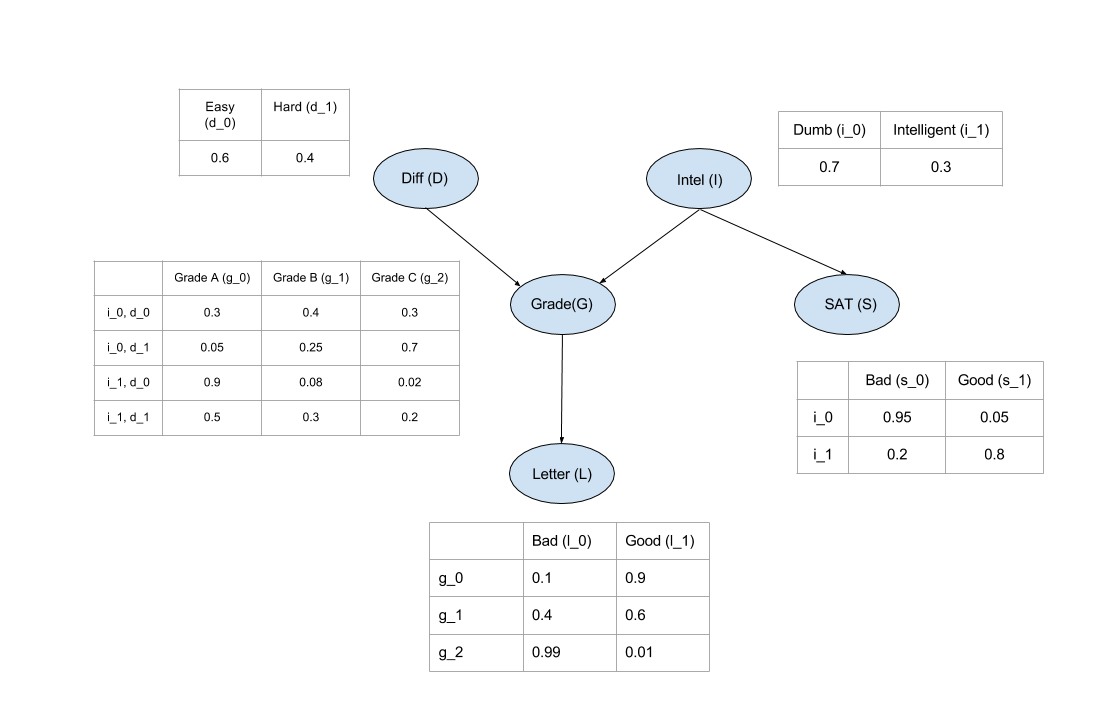

In [2]:
from IPython.display import Image
Image('student_net.png')

### Se crean top-down por la estructura de dependencias

In [5]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD

model = BayesianNetwork([('D', 'G'), ('I', 'G'), ('G', 'L'), ('I', 'S')])


cpd_d_sn = TabularCPD(variable='D', variable_card=2, values=[[0.6], [0.4]], state_names={'D': ['Easy', 'Hard']})
cpd_i_sn = TabularCPD(variable='I', variable_card=2, values=[[0.7], [0.3]], state_names={'I': ['Dumb', 'Intelligent']})
cpd_g_sn = TabularCPD(variable='G', variable_card=3,
                      values=[[0.3, 0.05, 0.9,  0.5],
                              [0.4, 0.25, 0.08, 0.3],
                              [0.3, 0.7,  0.02, 0.2]],
                      evidence=['I', 'D'],
                      evidence_card=[2, 2],
                      state_names={'G': ['A', 'B', 'C'],
                                   'I': ['Dumb', 'Intelligent'],
                                   'D': ['Easy', 'Hard']})

cpd_l_sn = TabularCPD(variable='L', variable_card=2,
                      values=[[0.1, 0.4, 0.99],
                              [0.9, 0.6, 0.01]],
                      evidence=['G'],
                      evidence_card=[3],
                      state_names={'L': ['Bad', 'Good'],
                                   'G': ['A', 'B', 'C']})

cpd_s_sn = TabularCPD(variable='S', variable_card=2,
                      values=[[0.95, 0.2],
                              [0.05, 0.8]],
                      evidence=['I'],
                      evidence_card=[2],
                      state_names={'S': ['Bad', 'Good'],
                                   'I': ['Dumb', 'Intelligent']})


model.add_cpds(cpd_d_sn, cpd_i_sn, cpd_g_sn, cpd_l_sn, cpd_s_sn)
model.check_model()

True

### Podemos obtener la CPD en cualquier nodo de la red

In [7]:
print(model.get_cpds('G'))

+------+---------+---------+----------------+----------------+
| I    | I(Dumb) | I(Dumb) | I(Intelligent) | I(Intelligent) |
+------+---------+---------+----------------+----------------+
| D    | D(Easy) | D(Hard) | D(Easy)        | D(Hard)        |
+------+---------+---------+----------------+----------------+
| G(A) | 0.3     | 0.05    | 0.9            | 0.5            |
+------+---------+---------+----------------+----------------+
| G(B) | 0.4     | 0.25    | 0.08           | 0.3            |
+------+---------+---------+----------------+----------------+
| G(C) | 0.3     | 0.7     | 0.02           | 0.2            |
+------+---------+---------+----------------+----------------+


### Y obtenemos las relaciones de dependencia entre las variables de la red

In [8]:
model.local_independencies(['D', 'I', 'S', 'G', 'L'])

(D ⟂ S, I)
(I ⟂ D)
(S ⟂ G, L, D | I)
(G ⟂ S | I, D)
(L ⟂ S, D, I | G)

### Ahora marginalizamos

In [9]:
from pgmpy.inference import VariableElimination

infer = VariableElimination(model)
g_dist = infer.query(['G'])

print(infer.query(['G'], evidence={'D': 'Easy', 'I': 'Intelligent'}))

+------+----------+
| G    |   phi(G) |
+======+==========+
| G(A) |   0.9000 |
+------+----------+
| G(B) |   0.0800 |
+------+----------+
| G(C) |   0.0200 |
+------+----------+


### Nos interesará aprender una red desde observaciones (model fitting)

In [10]:
import pandas as pd
data = pd.DataFrame(data={'fruit': ["banana", "apple", "banana", "apple", "banana","apple", "banana",
                                    "apple", "apple", "apple", "banana", "banana", "apple", "banana",],
                          'tasty': ["yes", "no", "yes", "yes", "yes", "yes", "yes",
                                    "yes", "yes", "yes", "yes", "no", "no", "no"],
                          'size': ["large", "large", "large", "small", "large", "large", "large",
                                    "small", "large", "large", "large", "large", "small", "small"]})
print(data)

     fruit tasty   size
0   banana   yes  large
1    apple    no  large
2   banana   yes  large
3    apple   yes  small
4   banana   yes  large
5    apple   yes  large
6   banana   yes  large
7    apple   yes  small
8    apple   yes  large
9    apple   yes  large
10  banana   yes  large
11  banana    no  large
12   apple    no  small
13  banana    no  small


### Podemos conocer la estructura de dependencias

In [11]:
model = BayesianNetwork([('fruit', 'tasty'), ('size', 'tasty')])

### Y a partir de estas dependencias calculamos los parámetros de la red, primro las cuentas de cada cruce

In [12]:
from pgmpy.estimators import ParameterEstimator
pe = ParameterEstimator(model, data)
print("\n", pe.state_counts('fruit'))  # unconditional
print("\n", pe.state_counts('tasty'))  # conditional on fruit and size


         fruit
apple       7
banana      7

 fruit apple       banana      
size  large small  large small
tasty                         
no      1.0   1.0    1.0   1.0
yes     3.0   2.0    5.0   0.0


### Y luego las CPD usando MLE

In [13]:
from pgmpy.estimators import MaximumLikelihoodEstimator
mle = MaximumLikelihoodEstimator(model, data)
print(mle.estimate_cpd('fruit'))  # unconditional
print(mle.estimate_cpd('tasty'))  # conditional

+---------------+-----+
| fruit(apple)  | 0.5 |
+---------------+-----+
| fruit(banana) | 0.5 |
+---------------+-----+
+------------+--------------+-----+---------------+
| fruit      | fruit(apple) | ... | fruit(banana) |
+------------+--------------+-----+---------------+
| size       | size(large)  | ... | size(small)   |
+------------+--------------+-----+---------------+
| tasty(no)  | 0.25         | ... | 1.0           |
+------------+--------------+-----+---------------+
| tasty(yes) | 0.75         | ... | 0.0           |
+------------+--------------+-----+---------------+


### Si tenemos pocos datos, la red va a sobreajustarse por lo que usaremos priors, en este caso priors de Dirichlet

In [14]:
from pgmpy.estimators import BayesianEstimator
est = BayesianEstimator(model, data)

print(est.estimate_cpd('tasty', prior_type='BDeu', equivalent_sample_size=10))

INFO:numexpr.utils:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


+------------+---------------------+-----+---------------------+
| fruit      | fruit(apple)        | ... | fruit(banana)       |
+------------+---------------------+-----+---------------------+
| size       | size(large)         | ... | size(small)         |
+------------+---------------------+-----+---------------------+
| tasty(no)  | 0.34615384615384615 | ... | 0.6428571428571429  |
+------------+---------------------+-----+---------------------+
| tasty(yes) | 0.6538461538461539  | ... | 0.35714285714285715 |
+------------+---------------------+-----+---------------------+


### Podemos usar priors para estimar todos los parámetros del modelo

In [15]:
import numpy as np
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator

# generate data
data = pd.DataFrame(np.random.randint(low=0, high=2, size=(5000, 4)), columns=['A', 'B', 'C', 'D'])
model = BayesianNetwork([('A', 'B'), ('A', 'C'), ('D', 'C'), ('B', 'D')])

model.fit(data, estimator=BayesianEstimator, prior_type="BDeu") # default equivalent_sample_size=5
for cpd in model.get_cpds():
    print(cpd)

+------+----------+
| A(0) | 0.502597 |
+------+----------+
| A(1) | 0.497403 |
+------+----------+
+------+--------------------+--------------------+
| A    | A(0)               | A(1)               |
+------+--------------------+--------------------+
| B(0) | 0.5137149672033393 | 0.5058244627435228 |
+------+--------------------+--------------------+
| B(1) | 0.4862850327966607 | 0.4941755372564772 |
+------+--------------------+--------------------+
+------+---------------------+-----+------------------+
| A    | A(0)                | ... | A(1)             |
+------+---------------------+-----+------------------+
| D    | D(0)                | ... | D(1)             |
+------+---------------------+-----+------------------+
| C(0) | 0.5057681215150932  | ... | 0.51679983609916 |
+------+---------------------+-----+------------------+
| C(1) | 0.49423187848490674 | ... | 0.48320016390084 |
+------+---------------------+-----+------------------+
+------+-------------------+-----------

### Si no conocemos las dependencias, las podemos calcular. Necesitaremos un criterio de selección para los modelos. Usaremos el BIC (mayor es mejor).

In [17]:
import pandas as pd
import numpy as np
from pgmpy.estimators import BicScore
from pgmpy.models import BayesianNetwork

data = pd.DataFrame(np.random.randint(0, 4, size=(5000, 2)), columns=list('XY'))
data['Z'] = data['X'] + data['Y']

bic = BicScore(data)

model1 = BayesianNetwork([('X', 'Z'), ('Y', 'Z')])  # X -> Z <- Y
model2 = BayesianNetwork([('X', 'Z'), ('X', 'Y')])  # Y <- X -> Z

print(bic.score(model1))

print(bic.score(model2))

-14293.862363353142
-20947.395937619713


### Podemos buscar sobre todas las posibles relaciones de dependencia entre las variables con búsqueda exhaustiva

In [18]:
from pgmpy.estimators import ExhaustiveSearch

es = ExhaustiveSearch(data, scoring_method=bic)
best_model = es.estimate()
print(best_model.edges())

print("\nAll DAGs by score:")
for score, dag in reversed(es.all_scores()):
    print(score, dag.edges())

[('X', 'Z'), ('Y', 'Z')]

All DAGs by score:
-14293.862363353142 [('X', 'Z'), ('Y', 'Z')]
-14328.09556498613 [('Y', 'Z'), ('Y', 'X'), ('Z', 'X')]
-14328.09556498613 [('X', 'Y'), ('Z', 'X'), ('Z', 'Y')]
-14328.095564986132 [('Y', 'X'), ('Z', 'X'), ('Z', 'Y')]
-14328.095564986132 [('X', 'Z'), ('Y', 'Z'), ('Y', 'X')]
-14328.095564986132 [('X', 'Y'), ('X', 'Z'), ('Z', 'Y')]
-14328.095564986132 [('X', 'Y'), ('X', 'Z'), ('Y', 'Z')]
-16573.255369617596 [('X', 'Y'), ('Z', 'Y')]
-16573.796849532584 [('Y', 'X'), ('Z', 'X')]
-18667.461451440267 [('Y', 'Z'), ('Z', 'X')]
-18667.46145144027 [('Z', 'X'), ('Z', 'Y')]
-18667.46145144027 [('X', 'Z'), ('Z', 'Y')]
-20912.621256071736 [('Z', 'Y')]
-20912.621256071736 [('Y', 'Z')]
-20913.162735986723 [('Z', 'X')]
-20913.162735986723 [('X', 'Z')]
-20946.85445770472 [('Y', 'X'), ('Z', 'Y')]
-20946.854457704725 [('Y', 'Z'), ('Y', 'X')]
-20946.854457704725 [('X', 'Y'), ('Y', 'Z')]
-20947.39593761971 [('X', 'Y'), ('Z', 'X')]
-20947.395937619713 [('X', 'Z'), ('Y'

### O bien podemos buscar usando una heurística

In [19]:
from pgmpy.estimators import HillClimbSearch

# create some data with dependencies
data = pd.DataFrame(np.random.randint(0, 3, size=(2500, 8)), columns=list('ABCDEFGH'))
data['A'] += data['B'] + data['C']
data['H'] = data['G'] - data['A']

hc = HillClimbSearch(data)
best_model = hc.estimate(scoring_method=BicScore(data))
print(best_model.edges())

[('A', 'H'), ('B', 'A'), ('C', 'A'), ('G', 'H')]
